**Implement Multi Factor Model in OOP**

Steps:
1. At each time, for all stocks in the universe, rank them by the each factor respectively and divide stocks into 2 groups. Factors' returns ($F$) are then calculated as the difference of average return between these 2 groups.
2. For each stock ($i$), perform a time series regression of stock return on the 6 factor returns. This generates sensitivites of return relative to the factors ($b$), for each single stock.

&emsp;&emsp;$R_i - R_f = a_i + b_{i1} F_1 + b_{i2} F_2 + \ldots + b_{iK} F_K + \epsilon_i$


3. For each time, perform a cross section regression of stock return on the set of sensitivity ($b$) generated in previous part. This generates the market risk premium ($\lambda$)and the 6 factors premium.

&emsp;&emsp;$R_i - R_f = a_i + b_{i1} \lambda_1 + b_{i2} \lambda_2 + \ldots + b_{iK} \lambda_K + \epsilon_i$

4. The risk premium is the average of $\lambda$ at all time t.

Let's define the fundamentals in Quantopian language, and create the model for the recent 5 years.
It is observed that momentum factor is the top performer and value factor is the worst. Min Volatility factor is the second best.

Sources: https://www.quantopian.com/lectures/the-capital-asset-pricing-model-and-arbitrage-pricing-theory

In [ ]:
# global variable funda, is used to store the factor names, H-L/L-H indicators 
# and the quantopian morning star fundamentals
global funda
funda = [
        #Size (low-high)
        ['SIZE', 'L-H', Latest([Fundamentals.market_cap])**(0.5)],\
        #Min Volatility (low-high)
        ['VOL',  'L-H', AnnualizedVolatility(window_length=2)],\
        #value (low-high)
        ['VAL',  'L-H', Latest([Fundamentals.pb_ratio])],\
        #Momentum (high-low)
        ['MMT',  'H-L', (1+Returns(window_length=21*12))/(1+Returns(window_length=12))],\
        #Quality (high-low)
        ['QLT',  'H-L', -0.5*Latest([Fundamentals.total_debt_equity_ratio]).zscore() +\
                         0.5*Latest([Fundamentals.roe]).zscore()]       
        ]

# Create models year by year
from datetime import date

a_r_prem=[]
d_r_prem=[]
i=2014

while i + 1 < 2020:
    model = factor_model(start_date = date(i,12,2),     # Use monthly rolling return, query data for 13 months
                         end_date   = date(i+1,12,31),  
                         factor     = funda,            # use the Fundamentals defined above
                         rf         = 'BIL',            # 1-3 month T-Bil ETF as risk free rate
                         rm         = 'SPY',            # S&P500 ETF as market return
                         window     = 21,               # 1 month rolling return
                         split      = 0.3)              # Construct factor returns by top 30% and bottom 30% rank 
    
    d_r_prem.append(model.r_prem)
    a_r_prem.append(model.a_r_prem)
    
    i+=1

In [45]:
# annualized factor risk premium
pd.concat(a_r_prem,axis=0)*100

,rp_MARKET,rp_SIZE,rp_VOL,rp_VAL,rp_MMT,rp_QLT
2015,-0.056971,0.767650,8.484743,-8.367717,18.593770,4.511718
2016,5.899436,5.425983,9.088620,6.525881,-3.013225,-3.302244
2017,0.228201,-0.543545,-1.850452,-7.482273,18.039002,5.210603
2018,0.320691,2.891234,5.810477,-8.035138,11.421590,-1.348823
2019,6.317836,2.615127,5.074900,-12.212638,9.418417,-0.611954


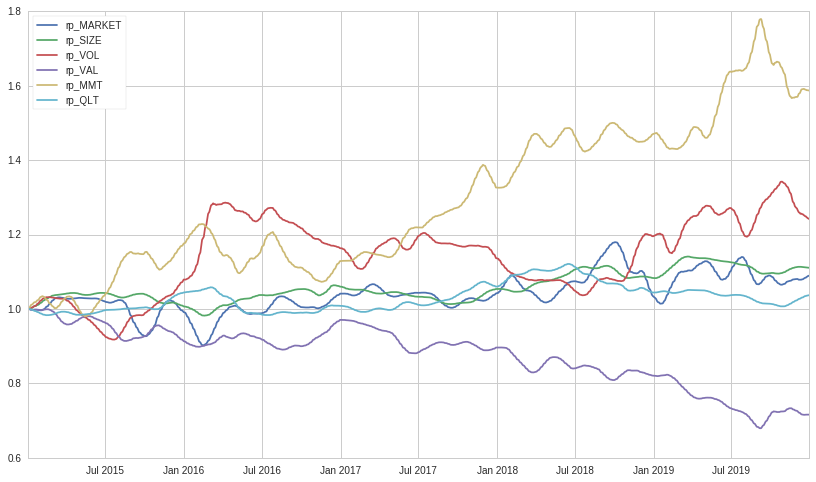

In [46]:
def timeseries(ts):
    for i in ts.columns:
        plt.plot(ts[i],label=i)
    plt.legend(loc="upper left")

import matplotlib.pyplot as plt
test = (pd.concat(d_r_prem,axis=0)+1)**(1/21)
test =test.cumprod()
timeseries(test)